In [151]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import pickle
import os
from wordcloud import WordCloud
from datasets import load_dataset

In [152]:
df = pd.read_csv('all_articles.csv')

In [153]:
df = pd.read_csv('all_articles.csv')
print(f"Số lượng dòng dữ liệu: {len(df)}")
df.head()

Số lượng dòng dữ liệu: 1752


,url,source,crawl_time,category,title,description,publish_time,content,author
0,https://tuoitre.vn/tong-bi-thu-to-lam-xay-dung...,tuoitre,2025-03-12 22:28:11,cong-nghe,"Tổng Bí thư Tô Lâm: Xây dựng, ban hành danh mụ...",NaN,NaN,Tổng Bí thư Tô Lâm chủ trì phiên họp - Ảnh: TT...,THÀNH CHUNG
1,https://tuoitre.vn/cau-noi-viettel-xay-nen-gia...,tuoitre,2025-03-12 22:28:40,cong-nghe,‘Cầu nối’ Viettel xây nên giấc mơ giáo dục ‘kh...,NaN,NaN,"Trong gần 2 thập kỷ, Internet trường học đã gi...",VIETTEL - T.HÀ
2,https://tuoitre.vn/chi-dung-y-nghi-nguoi-dan-o...,tuoitre,2025-03-12 22:29:09,cong-nghe,"Chỉ dùng ý nghĩ, người đàn ông bị liệt có thể ...",NaN,NaN,Giáo sư thần kinh học Karunesh Ganguly (giữa) ...,TTXVN
3,https://tuoitre.vn/bat-ngo-vi-lam-ly-lich-tu-p...,tuoitre,2025-03-12 22:29:40,cong-nghe,Bất ngờ vì làm lý lịch tư pháp qua VNeID thuận...,NaN,NaN,Một số người dân vẫn đến trực tiếp làm thủ tục...,ÁI NHÂN
4,https://tuoitre.vn/xac-thuc-dien-tu-qua-vneid-...,tuoitre,2025-03-12 22:30:11,cong-nghe,"Xác thực điện tử qua VNeID tăng cường an ninh,...",NaN,NaN,Trung tâm RAR (Bộ Công an) và Sacombank ký kết...,DANH TRỌNG


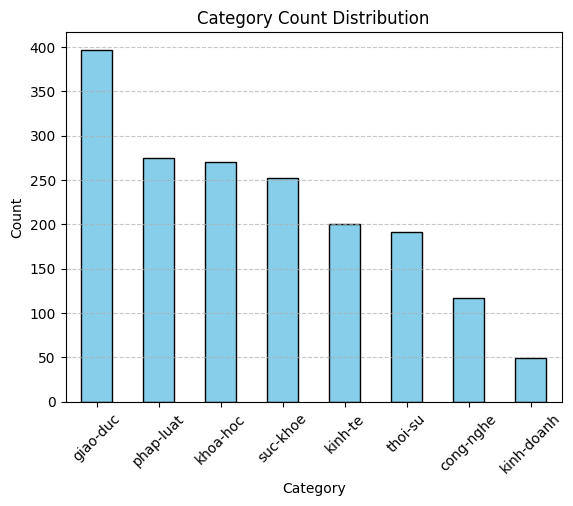

In [154]:
import matplotlib.pyplot as plt

# Plot bar chart
df['category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Category Count Distribution")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [155]:
# Chuyển đổi thời gian thu thập dữ liệu thành định dạng datetime
df["crawl_time"] = pd.to_datetime(df["crawl_time"])

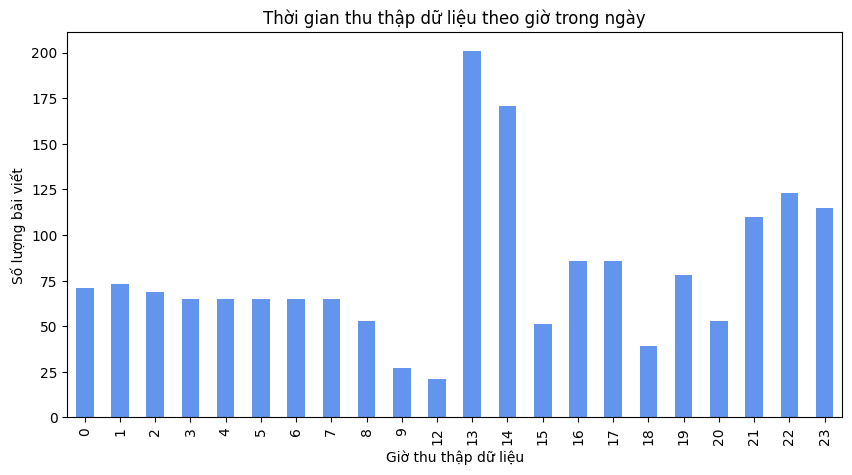

In [156]:
# 2. Biểu đồ thời gian thu thập dữ liệu
df["crawl_time"].dt.hour.value_counts().sort_index().plot(kind="bar", figsize=(10, 5), color="cornflowerblue")
plt.xlabel("Giờ thu thập dữ liệu")
plt.ylabel("Số lượng bài viết")
plt.title("Thời gian thu thập dữ liệu theo giờ trong ngày")
plt.show()

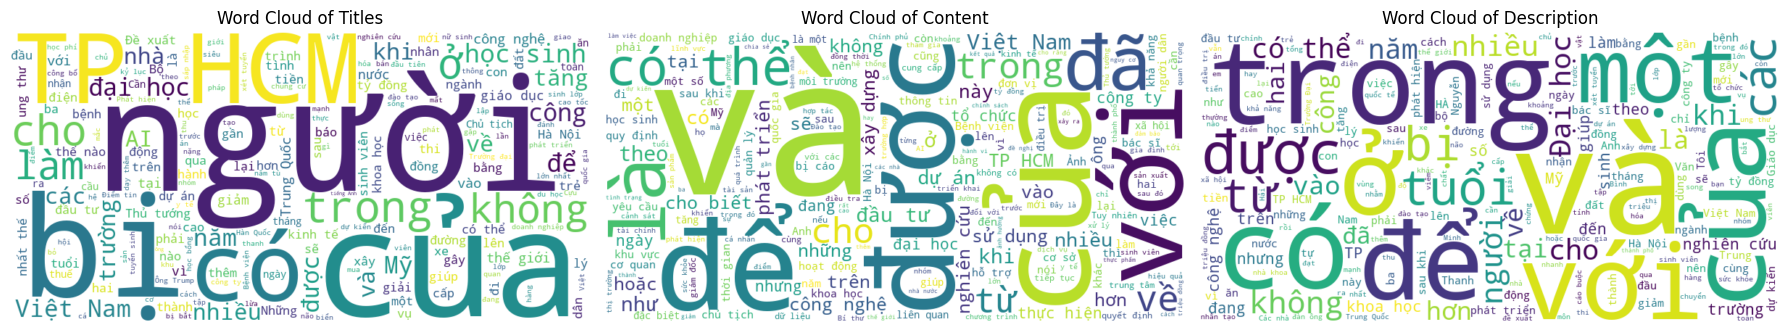

In [157]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word clouds
text_title = " ".join(df['title'].dropna())
text_content = " ".join(df['content'].dropna())
text_description = " ".join(df['description'].dropna())

wordcloud_title = WordCloud(width=800, height=400, background_color='white').generate(text_title)
wordcloud_content = WordCloud(width=800, height=400, background_color='white').generate(text_content)
wordcloud_description = WordCloud(width=800, height=400, background_color='white').generate(text_description)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Title Word Cloud
axes[0].imshow(wordcloud_title, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Word Cloud of Titles")

# Content Word Cloud
axes[1].imshow(wordcloud_content, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Word Cloud of Content")

# Description Word Cloud
axes[2].imshow(wordcloud_description, interpolation='bilinear')
axes[2].axis("off")
axes[2].set_title("Word Cloud of Description")

# Show the plot
plt.tight_layout()
plt.show()


C:\Users\VUHUY\AppData\Local\Temp\ipykernel_28872\1515927738.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=word_freq, palette='viridis')


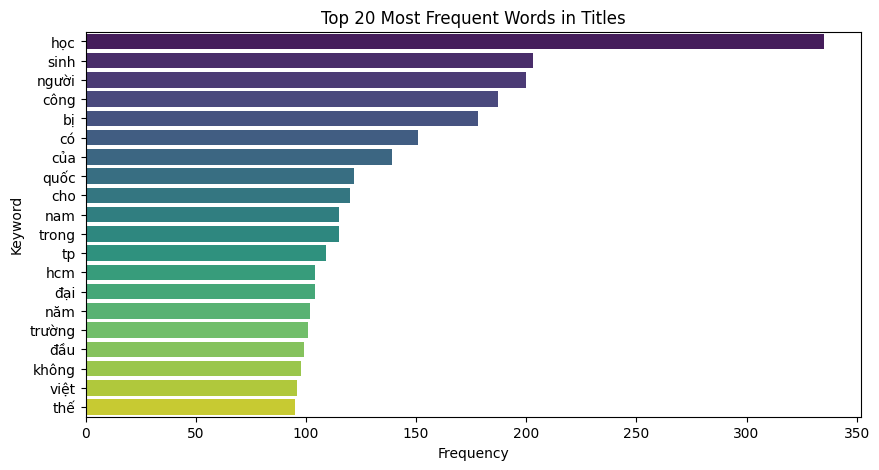

In [158]:
# 3. Word Frequency Chart in Titles
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['title'].dropna())

word_counts = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
word_freq = pd.DataFrame({'word': words, 'count': word_counts}).sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=word_freq, palette='viridis')
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.title("Top 20 Most Frequent Words in Titles")
plt.show()


In [159]:
# Xử lý dữ liệu
# Chỉ lấy các cột cần thiết cho việc phân loại
df_clean = df[['category', 'title', 'content', 'description']].copy()

In [160]:
df

,url,source,crawl_time,category,title,description,publish_time,content,author
0,https://tuoitre.vn/tong-bi-thu-to-lam-xay-dung...,tuoitre,2025-03-12 22:28:11,cong-nghe,"Tổng Bí thư Tô Lâm: Xây dựng, ban hành danh mụ...",NaN,NaN,Tổng Bí thư Tô Lâm chủ trì phiên họp - Ảnh: TT...,THÀNH CHUNG
1,https://tuoitre.vn/cau-noi-viettel-xay-nen-gia...,tuoitre,2025-03-12 22:28:40,cong-nghe,‘Cầu nối’ Viettel xây nên giấc mơ giáo dục ‘kh...,NaN,NaN,"Trong gần 2 thập kỷ, Internet trường học đã gi...",VIETTEL - T.HÀ
2,https://tuoitre.vn/chi-dung-y-nghi-nguoi-dan-o...,tuoitre,2025-03-12 22:29:09,cong-nghe,"Chỉ dùng ý nghĩ, người đàn ông bị liệt có thể ...",NaN,NaN,Giáo sư thần kinh học Karunesh Ganguly (giữa) ...,TTXVN
3,https://tuoitre.vn/bat-ngo-vi-lam-ly-lich-tu-p...,tuoitre,2025-03-12 22:29:40,cong-nghe,Bất ngờ vì làm lý lịch tư pháp qua VNeID thuận...,NaN,NaN,Một số người dân vẫn đến trực tiếp làm thủ tục...,ÁI NHÂN
4,https://tuoitre.vn/xac-thuc-dien-tu-qua-vneid-...,tuoitre,2025-03-12 22:30:11,cong-nghe,"Xác thực điện tử qua VNeID tăng cường an ninh,...",NaN,NaN,Trung tâm RAR (Bộ Công an) và Sacombank ký kết...,DANH TRỌNG
...,...,...,...,...,...,...,...,...,...
1747,https://tuoitre.vn/may-tam-nuoc-nong-den-tu-nh...,tuoitre,2025-03-14 21:03:43,cong-nghe,Máy tắm nước nóng đến từ Nhật Bản: Thư giãn an...,NaN,NaN,V.T.K,Ảnh: DNCC\nMáy tắm nước nóng là thiết bị không...
1748,https://tuoitre.vn/nganh-tai-chinh-ngan-hang-l...,tuoitre,2025-03-14 21:04:47,cong-nghe,Ngành tài chính - ngân hàng lương bỏ xa các ng...,NaN,NaN,VŨ THỦY,"Dải lương cho các vị trí quản lý, điều hành cấ..."
1749,https://tuoitre.vn/sau-lan-song-tang-gia-ao-gi...,tuoitre,2025-03-14 21:05:53,cong-nghe,"Sau làn sóng tăng giá ảo, giới đầu tư thận trọ...",NaN,NaN,HỒNG PHÚC,Nhân viên start-up Coolmate làm việc tại kho h...
1750,https://tuoitre.vn/pho-thu-tuong-ho-duc-phoc-t...,tuoitre,2025-03-14 21:10:22,cong-nghe,Phó thủ tướng Hồ Đức Phớc: Từ vụ Mr. Pips Phó ...,NaN,NaN,NGỌC AN,Hội nghị tổng kết Bộ Thông tin và Truyền thông...


In [161]:
# Kết hợp title và content để có nhiều thông tin hơn cho phân loại
df_clean['text'] = df_clean[['title', 'content', 'description']].fillna('').agg('. '.join, axis=1)


In [162]:
df_clean['text']

0       Tổng Bí thư Tô Lâm: Xây dựng, ban hành danh mụ...
1       ‘Cầu nối’ Viettel xây nên giấc mơ giáo dục ‘kh...
2       Chỉ dùng ý nghĩ, người đàn ông bị liệt có thể ...
3       Bất ngờ vì làm lý lịch tư pháp qua VNeID thuận...
4       Xác thực điện tử qua VNeID tăng cường an ninh,...
                              ...                        
1747    Máy tắm nước nóng đến từ Nhật Bản: Thư giãn an...
1748    Ngành tài chính - ngân hàng lương bỏ xa các ng...
1749    Sau làn sóng tăng giá ảo, giới đầu tư thận trọ...
1750    Phó thủ tướng Hồ Đức Phớc: Từ vụ Mr. Pips Phó ...
1751    Tổng Bí thư Tô Lâm: 'Lãnh đạo yếu kém, thiếu t...
Name: text, Length: 1752, dtype: object

In [163]:
# Tạo ánh xạ gộp các lớp
category_mapping = {
    'kinh-doanh': 'kinh-te',
    'khoa-hoc': 'cong-nghe'
}

# Áp dụng ánh xạ vào cột 'category'
df_clean['category'] = df_clean['category'].replace(category_mapping)

# Tạo ánh xạ từ category sang số
categories = df_clean['category'].unique()
category_to_id = {category: idx for idx, category in enumerate(categories)}
id_to_category = {idx: category for idx, category in enumerate(categories)}

print("Category to ID:", category_to_id)
print("ID to Category:", id_to_category)


Category to ID: {'cong-nghe': 0, 'giao-duc': 1, 'phap-luat': 2, 'suc-khoe': 3, 'thoi-su': 4, 'kinh-te': 5}
ID to Category: {0: 'cong-nghe', 1: 'giao-duc', 2: 'phap-luat', 3: 'suc-khoe', 4: 'thoi-su', 5: 'kinh-te'}


In [164]:
# Lưu ánh xạ để sử dụng khi dự đoán
with open('category_mapping.pkl', 'wb') as f:
    pickle.dump({'category_to_id': category_to_id, 'id_to_category': id_to_category}, f)

In [165]:
# Chuyển đổi category thành số
df_clean['label'] = df_clean['category'].map(category_to_id)

In [166]:
X = df_clean['text']
y = df_clean['label']

In [169]:
# Tách dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [170]:
# encode text data to numeric data
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Thiết lập tham số XGBoost cho phân loại nhiều lớp
params = {
    'max_depth': 10,            # Độ sâu tối đa của cây
    'learning_rate': 0.1,      # Tốc độ học
    'n_estimators': 300,       # Số lượng cây
    'objective': 'multi:softmax',  # Phân loại nhiều lớp (softmax)
    'num_class': len(set(y_train)),  # Số lớp đầu ra
    'eval_metric': 'mlogloss',  # Hàm mất mát cho phân loại nhiều lớp
    'random_state': 42
}

# Khởi tạo mô hình XGBoost
model = xgb.XGBClassifier(**params)

# Huấn luyện mô hình
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=100)  


[0]	validation_0-mlogloss:1.64408	validation_1-mlogloss:1.68829
[100]	validation_0-mlogloss:0.14613	validation_1-mlogloss:0.74744
[199]	validation_0-mlogloss:0.06024	validation_1-mlogloss:0.73701


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=6, num_parallel_tree=None, ...)

In [174]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {accuracy:.4f}")

# Xem báo cáo phân loại
print(classification_report(y_test, y_pred))

🎯 Accuracy: 0.7749
              precision    recall  f1-score   support

           0       0.80      0.77      0.79        74
           1       0.85      0.86      0.85        84
           2       0.80      0.80      0.80        55
           3       0.86      0.78      0.82        54
           4       0.79      0.65      0.71        46
           5       0.51      0.71      0.59        38

    accuracy                           0.77       351
   macro avg       0.77      0.76      0.76       351
weighted avg       0.79      0.77      0.78       351



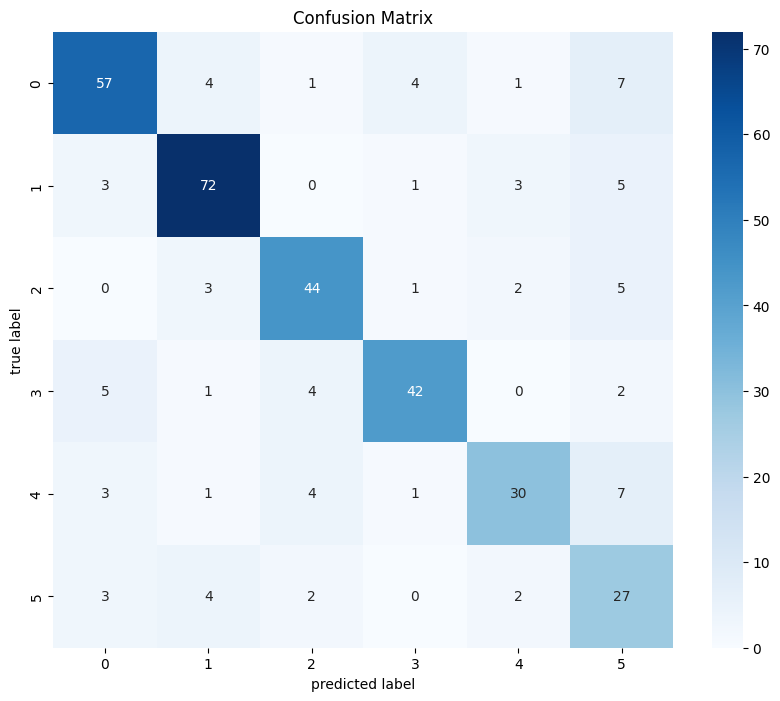

In [183]:
# Bước 5: Trực quan hóa kết quả
# Ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(set(y_train)), 
            yticklabels=sorted(set(y_train)))
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [180]:
# Tạo báo cáo chi tiết
print("\nBáo cáo chi tiết về mô hình XGBoost:")
print(f"Số lượng cây (n_estimators): {model.n_estimators}")
print(f"Độ sâu tối đa (max_depth): {model.max_depth}")
print(f"Tỉ lệ học (learning_rate): {model.learning_rate}")


Báo cáo chi tiết về mô hình XGBoost:
Số lượng cây (n_estimators): 200
Độ sâu tối đa (max_depth): 6
Tỉ lệ học (learning_rate): 0.1


In [182]:
pickle.dump(model, open("xgboost_text_classifier.pkl", "wb"))

pickle.dump(vectorizer, open("tfidf_vectorizer.pkl", "wb"))